# Simulation of SEIARV model



In [ ]:

import pandas as pd

from wbepi import models as md
import numpy as np
import matplotlib.pyplot as plt

# for details of SEIARV model, see wbepi.models
ctrl_C = lambda t: 0.5
ctrl_D = lambda t: 0.8
wbe_model = md.SEIARV(ctrl_C, ctrl_D)
A = wbe_model.ode_sol()
plt.plot(A["tspan"], A["solution"][:, 2])
plt.show()

# Sensitivity Analysis

In [ ]:
from wbepi import sensitivity as st
from wbepi import basic_models as md
import numpy as np
import matplotlib.pyplot as plt

# SIRmode as a test

prob = {"num_vars": 2,
        "names": ["beta", "gamma"],
        # ‘groups’:[‘g1′,’g1′,’g2′,’g2′,’g3’],
        "bounds": [[0.1, 0.9], [0.1, 0.5]],
        "dists": ["unif", "unif"]
        }
Nsum = 1000
X = st.LHS(prob, Nsum)

tspan1 = np.arange(0, 200, 0.1)
Y = np.zeros((len(tspan1), Nsum))
for i in np.arange(Nsum):
    wbe_model = md.SIR(beta=X[i, 0], gamma=X[i, 1])
    A = wbe_model.ode_sol()
    #print(A["solution"])
    Y[:, i] = A["solution"][:, 1]

Sen_results1 = np.zeros((len(tspan1), 2))
Sen_results2 = np.zeros((len(tspan1), 2))
for j in np.arange(len(tspan1)):
    K = Y[j, :]
    Sen_results1[j, :] = st.PRCC(X, K)
    Sen_results2[j, :] = st.RBD_FAST(prob, X, K)
    #Si1  = morris.analyze(prob, X, K, conf_level=0.95, print_to_console=False, num_levels=4)
    #Sen_results2[j,:]=Si["S1"]
plt.figure(1)
plt.plot(A["tspan"], Sen_results1[:, 0], label="beta_method_one")
plt.plot(A["tspan"], Sen_results2[:, 0], label="beta_method_two")
plt.plot(A["tspan"], Sen_results1[:, 1], label="gamma_method_one")
plt.plot(A["tspan"], Sen_results2[:, 1], label="gamma_method_two")
plt.show()

# Parameter Estimation by nonlinear least square method and approximate bayesian method

Package: lmfit, pyABC

## NLES method

SIR Model as a test

In [ ]:
from wbepi import basic_models as md
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Parameters, minimize, report_fit
import pandas as pd

# Method One: Nonlinear Least Square Method
## test_data generation
para_test_model = md.SIR(beta=0.2, gamma=0.1, t0=0, dt=5, tend=150)
test_data = para_test_model.ode_sol()
plt.figure(1)
sns.set_theme(style="darkgrid")
plt.plot(test_data["tspan"], test_data["solution"][:, 1])
plt.show()

## parameter estimation by using lmfit
para_estimated = Parameters()
para_estimated.add('beta', value=0.01, min=0, max=1)
para_estimated.add('gamma', value=0.02, min=0, max=1)


# define error function
def error(para):
    para_model = md.SIR(beta=para["beta"], gamma=para["gamma"], t0=0, dt=5, tend=150)
    model_data = para_model.ode_sol()
    mse = model_data["solution"][:, 1] - test_data["solution"][:, 1]  # only data-data needed
    return mse


# Parameter estimation
out = minimize(error, para_estimated)
report_fit(out.params)
print(error(out.params))
# Show fitting results
result_model = md.SIR(beta=out.params["beta"], gamma=out.params["gamma"], t0=0, dt=1, tend=150)
result_data = result_model.ode_sol()

plt.figure(2)
sns.set_theme(style="darkgrid")
plt.plot(test_data["tspan"], test_data["solution"][:, 1], "o")
plt.plot(result_data["tspan"], result_data["solution"][:, 1])
plt.show()


basic reproduction number: 1.919642857142857


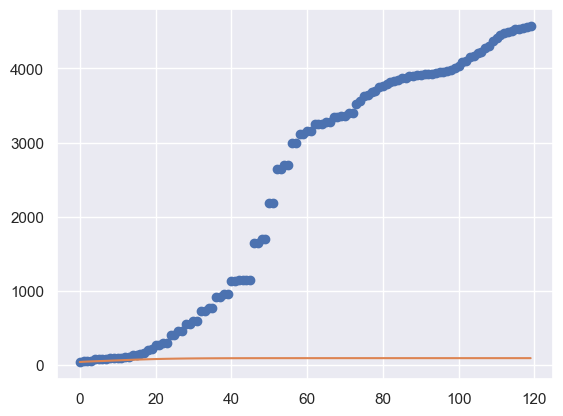

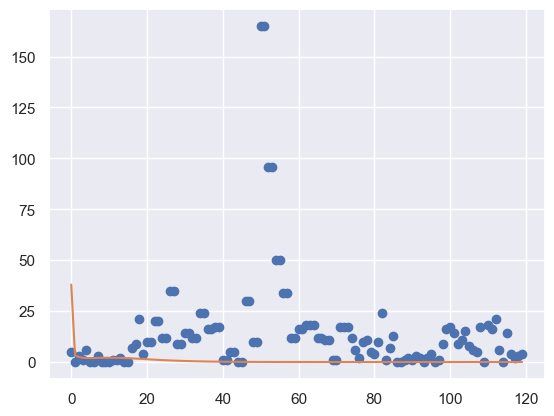

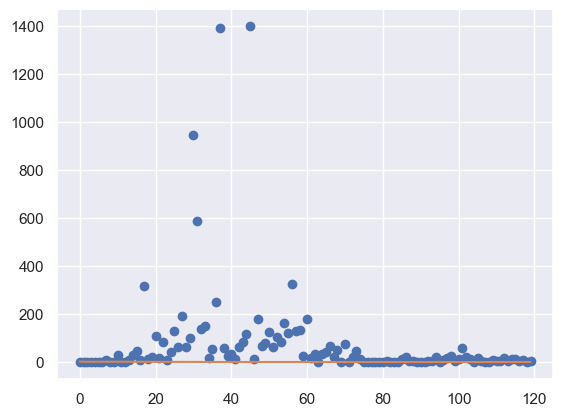

In [1]:

from wbepi import models as md
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Parameters, minimize, report_fit
import pandas as pd

# Data import
source_data = pd.read_csv("./Data/albany_merge_data.csv")
Fit_data = pd.DataFrame(index=source_data.index, columns=["date", "confirmed", "newlyconfirmed",
                                                          "water_virus"])
Fit_data["date"] = pd.to_datetime(source_data["date"])
Fit_data["confirmed"] = source_data["confirmed"].values
Fit_data["newlyconfirmed"] = source_data["newlyconfirmed"].values
Fit_data["water_virus"] = source_data["Est. concentration"].values

beta = 0.4
ca = 0.1
cr = 0.9
k = 5
# initial values
initvalue_data = {"initS": 32711, "initE": k, "initA": k, "initI": k, "initD": 38,
                  "initR1": 0, "initR2": 0,
                  "initW": 2}
timepara_data = {"t0": 0, "dt": 1, "tend": int(len(Fit_data.index))}
# Parameters

para_set = Parameters()
para_set.add("ca", value=ca, vary=False)
para_set.add("cr", value=cr, vary=False)
para_set.add('N', value=32711, vary=False)
para_set.add('beta', value=beta, vary=False)  # Estimated
para_set.add('k_E', value=0.55, vary=False)
para_set.add('k_A', value=0.55, vary=False)
para_set.add('sigma', value=1 / 5.8, vary=False)
para_set.add('rho', value=0.31, vary=False)
para_set.add('gamma_I', value=1 / 12, vary=False)
para_set.add('gamma_A', value=1 / 10, vary=False)
para_set.add('gamma_R', value=1 / 13, vary=False)
para_set.add('detecting_A', value=0.3, vary=False)  # estimated
para_set.add('detecting_I', value=0.5, vary=False)  # estimated
para_set.add('log_p_0', value=3, vary=False)  # estimated
para_set.add('p_E', value=0.1, vary=False)
para_set.add('p_A', value=0.1, vary=False)
para_set.add('p_R', value=0.1, vary=False)
para_set.add('water_volume', value=3000, vary=False)
para_set.add('waning_rate', value=1.44, vary=False)


# Model solution
def solution(initvalue, timepara, para):
    ctrl1 = lambda t: np.power(para["cr"], t) + para["ca"]
    para_model = md.SEIARW(ctrl=ctrl1, initS=initvalue["initS"], initE=initvalue["initE"], initA=initvalue["initA"],
                           initI=initvalue["initI"], initD=initvalue["initD"], initR1=initvalue["initR1"],
                           initR2=initvalue["initR2"], initW=initvalue["initW"],
                           t0=timepara["t0"], dt=timepara["dt"], tend=timepara["tend"],
                           N=para["N"],
                           beta=para["beta"],
                           k_E=para["k_E"], k_A=para["k_A"], sigma=para["sigma"], rho=para["rho"],
                           gamma_I=para["gamma_I"], gamma_A=para["gamma_A"], gamma_R=para["gamma_R"],
                           detecting_A=para["detecting_A"], detacting_I=para["detecting_I"],
                           p_0=np.power(10, para["log_p_0"]), p_E=para["p_E"], p_A=para["p_A"], p_R=para["p_R"],
                           water_volume=para["water_volume"], waning_rate=para["waning_rate"])
    model_data = para_model.ode_sol()
    print("basic reproduction number:", para_model.BRN())
    return model_data


result_data = solution(initvalue_data, timepara_data, para_set)

plt.figure(2)
sns.set_theme(style="darkgrid")
plt.plot(Fit_data.index, Fit_data["confirmed"], "o")
plt.plot(result_data["tspan"], result_data["solution"][:, 4])
plt.show()

plt.figure(3)
sns.set_theme(style="darkgrid")
plt.plot(Fit_data.index, Fit_data["newlyconfirmed"], "o")
plt.plot(result_data["tspan"], result_data["newlyconfirmed"])
plt.show()
plt.figure(4)
sns.set_theme(style="darkgrid")
plt.plot(Fit_data.index, Fit_data["water_virus"], "o")
plt.plot(result_data["tspan"], result_data["solution"][:, 7])
plt.show()

# Parameter Estimation

        date  confirmed  newlyconfirmed  water_virus
0 2020-07-07         43             5.0          2.0
1 2020-07-09         45             0.0          0.0
2 2020-07-14         52             3.0          0.0
3 2020-07-16         54             1.0          0.0
4 2020-07-21         73             6.0          0.0
[[Variables]]
    ca:            0.29332289 (init = 0.3)
    cr:            0.96993127 (init = 0.3)
    N:             32711 (fixed)
    beta:          0.40921616 (init = 0.01)
    k_E:           0.55 (fixed)
    k_A:           0.55 (fixed)
    sigma:         0.1724138 (fixed)
    rho:           0.31 (fixed)
    gamma_I:       0.08333333 (fixed)
    gamma_A:       0.1 (fixed)
    gamma_R:       0.07692308 (fixed)
    detecting_A:   0.20724141 (init = 0.3)
    detecting_I:   0.50000000 (init = 0.5)
    log_p_0:       8.65023231 (init = 3)
    p_E:           0.1 (fixed)
    p_A:           0.1 (fixed)
    p_R:           0.1 (fixed)
    water_volume:  3000 (fixed)
    waning_ra

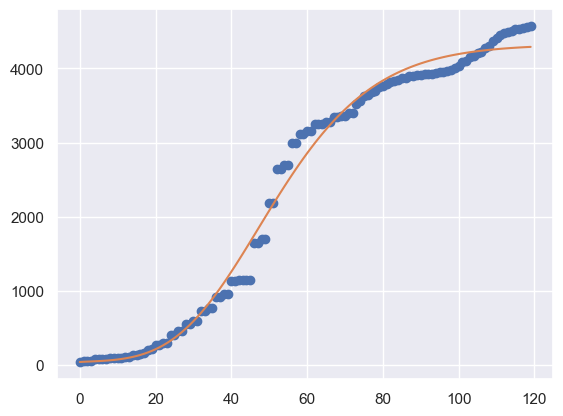

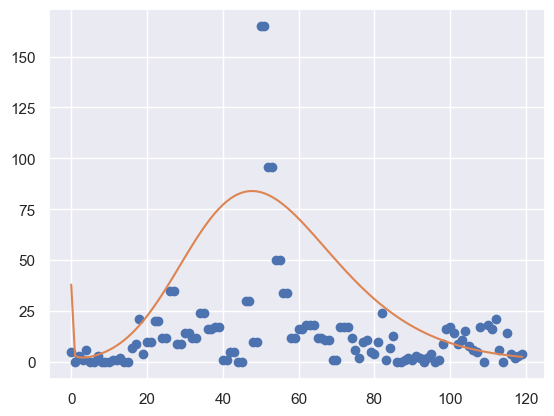

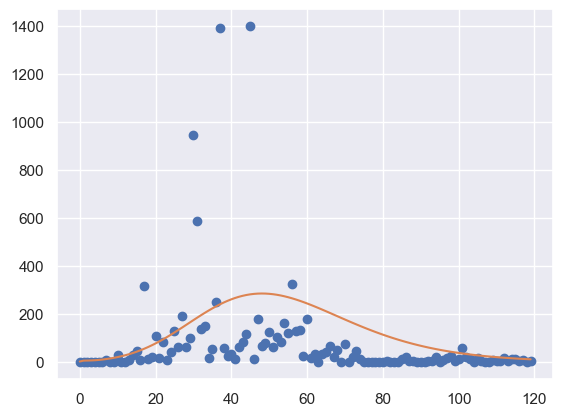

In [6]:
from wbepi import models as md
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Parameters, minimize, report_fit
import pandas as pd

# Data import
source_data = pd.read_csv("./Data/albany_merge_data.csv")
Fit_data = pd.DataFrame(index=source_data.index, columns=["date", "confirmed", "newlyconfirmed",
                                                          "water_virus"])
Fit_data["date"] = pd.to_datetime(source_data["date"])
Fit_data["confirmed"] = source_data["confirmed"].values
Fit_data["newlyconfirmed"] = source_data["newlyconfirmed"].values
Fit_data["water_virus"] = source_data["Est. concentration"].values
print(Fit_data.head())

# initial values
initvalue = {"initS": 32711, "initE": 5, "initA": 5, "initI": 5, "initD": 38,
             "initR1": 0, "initR2": 0,
             "initW": 2}
timepara = {"t0": 0, "dt": 1, "tend": int(len(Fit_data.index))}
# Parameters

para_set = Parameters()
para_set.add("ca", value=0.3, min=0, max=1)
para_set.add("cr", value=0.3, min=0, max=1)
para_set.add('N', value=32711, vary=False)
para_set.add('beta', value=0.01, min=0, max=10)  # Estimated
para_set.add('k_E', value=0.55, vary=False)
para_set.add('k_A', value=0.55, vary=False)
para_set.add('sigma', value=1 / 5.8, vary=False)
para_set.add('rho', value=0.31, vary=False)
para_set.add('gamma_I', value=1 / 12, vary=False)
para_set.add('gamma_A', value=1 / 10, vary=False)
para_set.add('gamma_R', value=1 / 13, vary=False)
para_set.add('detecting_A', value=0.3, min=0.2, max=0.5)  # estimated
para_set.add('detecting_I', value=0.5, min=0.5, max=1)  # estimated
para_set.add('log_p_0', value=3, min=1, max=9)  # estimated
para_set.add('p_E', value=0.1, vary=False)
para_set.add('p_A', value=0.1, vary=False)
para_set.add('p_R', value=0.1, vary=False)
para_set.add('water_volume', value=3000, vary=False)
para_set.add('waning_rate', value=1.44, vary=False)


# estimated


# define error function
def error(para):
    ctrl = lambda t: np.power(para["cr"], t) + para["ca"]
    para_model = md.SEIARW(ctrl=ctrl, initS=initvalue["initS"], initE=initvalue["initE"], initA=initvalue["initA"],
                           initI=initvalue["initI"], initD=initvalue["initD"], initR1=initvalue["initR1"],
                           initR2=initvalue["initR2"], initW=initvalue["initW"],
                           t0=timepara["t0"], dt=timepara["dt"], tend=timepara["tend"],
                           N=para["N"],
                           beta=para["beta"],
                           k_E=para["k_E"], k_A=para["k_A"], sigma=para["sigma"], rho=para["rho"],
                           gamma_I=para["gamma_I"], gamma_A=para["gamma_A"], gamma_R=para["gamma_R"],
                           detecting_A=para["detecting_A"], detacting_I=para["detecting_I"],
                           p_0=np.power(10, para["log_p_0"]), p_E=para["p_E"], p_A=para["p_A"], p_R=para["p_R"],
                           water_volume=para["water_volume"], waning_rate=para["waning_rate"])
    model_data = para_model.ode_sol()
    A=Fit_data["confirmed"].values>10
    B=Fit_data["newlyconfirmed"].values>1
    mse_1 = (model_data["solution"][A, 4] - Fit_data["confirmed"].values[A])
    mse_2 = (model_data["newlyconfirmed"][B]- Fit_data["newlyconfirmed"].values[B])
    mse_3 = (model_data["solution"][:, 7] - Fit_data["water_virus"].values) *\
            Fit_data["water_virus"].values
    return np.append(mse_1,mse_2)


# Parameter estimation
out = minimize(error, para_set)
report_fit(out.params)
print(error(out.params))
# Show fitting results
ctrl = lambda t: np.power(out.params["cr"], t) + out.params["ca"]
result_model = md.SEIARW(ctrl=ctrl, initS=initvalue["initS"], initE=initvalue["initE"], initA=initvalue["initA"],
                         initI=initvalue["initI"], initD=initvalue["initD"], initR1=initvalue["initR1"],
                         initR2=initvalue["initR2"], initW=initvalue["initW"],
                         t0=timepara["t0"], dt=timepara["dt"], tend=timepara["tend"],
                         N=out.params["N"],
                         beta=out.params["beta"],
                         k_E=out.params["k_E"], k_A=out.params["k_A"], sigma=out.params["sigma"], rho=out.params["rho"],
                         gamma_I=out.params["gamma_I"], gamma_A=out.params["gamma_A"], gamma_R=out.params["gamma_R"],
                         detecting_A=out.params["detecting_A"], detacting_I=out.params["detecting_I"],
                         p_0=np.exp(out.params["log_p_0"]), p_E=out.params["p_E"], p_A=out.params["p_A"],
                         p_R=out.params["p_R"],
                         water_volume=out.params["water_volume"], waning_rate=out.params["waning_rate"])
result_data = result_model.ode_sol()

plt.figure(2)
sns.set_theme(style="darkgrid")
plt.plot(Fit_data.index, Fit_data["confirmed"], "o")
plt.plot(result_data["tspan"], result_data["solution"][:, 4])
plt.show()

plt.figure(3)
sns.set_theme(style="darkgrid")
plt.plot(Fit_data.index, Fit_data["newlyconfirmed"], "o")
plt.plot(result_data["tspan"], result_data["newlyconfirmed"])
plt.show()
plt.figure(4)
sns.set_theme(style="darkgrid")
plt.plot(Fit_data.index, Fit_data["water_virus"], "o")
plt.plot(result_data["tspan"], result_data["solution"][:, 7])
plt.show()




